Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy Final: 78.95%


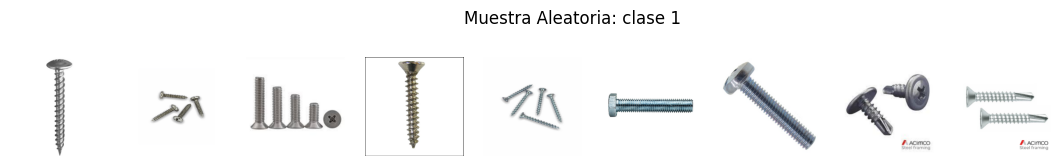

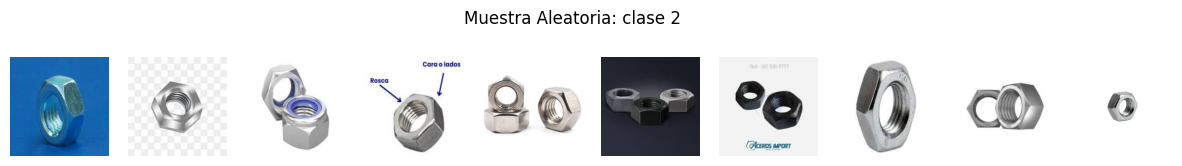

In [5]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')

PATH_DATASET = '/content/drive/MyDrive/Dataset'
CLASES = ['clase 1', 'clase 2']
CLASES = ['clase 1', 'clase 2']

k1 = np.array([[0,0,0],[0,1,0],[0,0,0]])
k2 = np.array([[0,1,0],[1,-4,1],[0,1,0]])

def extraer_caracteristicas_final(ruta):
    img = cv2.imread(ruta)
    if img is None: return None
    img = cv2.resize(img, (256, 256))
    gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    f_map_1 = cv2.filter2D(gris, -1, k1)
    f_map_2 = cv2.filter2D(gris, -1, k2)

    blur = cv2.GaussianBlur(f_map_1, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Característica 1: Intensidad promedio (Filtro 1)
    color_val = np.mean(f_map_1)

    # Característica 2: Elongación (Filtro 2)
    contornos, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contornos:
        c = max(contornos, key=cv2.contourArea)
        rect = cv2.minAreaRect(c)
        (x, y), (w, h), ang = rect
        elongacion = max(w, h) / min(w, h) if min(w, h) > 0 else 1
    else:
        elongacion = 1

    return [color_val, elongacion], img, f_map_1, f_map_2

X, y, imagenes_orig = [], [], []
for idx, clase in enumerate(CLASES):
    folder = os.path.join(PATH_DATASET, clase)
    archivos = [f for f in os.listdir(folder) if not f.startswith('.')]
    for f in archivos:
        res = extraer_caracteristicas_final(os.path.join(folder, f))
        if res:
            X.append(res[0]); y.append(idx); imagenes_orig.append(res[1])

X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

p1 = np.mean(X_norm[y == 0], axis=0)
p2 = np.mean(X_norm[y == 1], axis=0)
pred = np.array([0 if np.linalg.norm(f - p1) < np.linalg.norm(f - p2) else 1 for f in X_norm])

acc = accuracy_score(y, pred) * 100
print(f"Accuracy Final: {acc:.2f}%")

for idx, clase in enumerate(CLASES):
    plt.figure(figsize=(15, 2))
    plt.suptitle(f"Muestra Aleatoria: {clase}")
    indices = [i for i, label in enumerate(y) if label == idx]
    muestra = random.sample(indices, min(10, len(indices)))
    for i, m_idx in enumerate(muestra):
        plt.subplot(1, 10, i+1)
        plt.imshow(cv2.cvtColor(imagenes_orig[m_idx], cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()